In [1]:
pip install pykalman


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from pykalman import KalmanFilter
from scipy.stats.mstats import winsorize

In [3]:
def combine_md_datetime(df, date_col='MDDate', time_col='MDTime', new_col='DateTime',drop_original=True):
    """
    日期和时间合并为标准datetime
    """
    df[date_col] = df[date_col].astype(str)
    df[time_col] = df[time_col].astype(str).str.zfill(9)
    datetime_str = df[date_col] + ' ' + df[time_col].str[:6]
    df[new_col] = pd.to_datetime(datetime_str, format='%Y%m%d %H%M%S')
    
    if drop_original:
        df.drop(columns=[date_col, time_col], inplace=True)
    return df

In [6]:
# 加载数据
etf = pd.read_csv("../data/518880.SH_20250101_20250630.csv",usecols=['MDDate','MDTime','LastPx','Buy1Price','Sell1Price'])
au = pd.read_csv("../data/AU99.99.SGE_20250101_20250630.csv",usecols=['MDDate','MDTime', 'LastPx','Buy1Price','Sell1Price'])

#清洗
#区分价格
etf.rename(columns={'LastPx': 'ETF_Price','Buy1Price':'ETF_Buy1Price','Sell1Price':'ETF_Sell1Price'}, inplace=True)
au.rename(columns={'LastPx': 'AU_Price','Buy1Price':'AU_Buy1Price','Sell1Price':'AU_Sell1Price'}, inplace=True)

#删去0值
etf = etf[etf['ETF_Price'] != 0]
au = au[au['AU_Price'] != 0]

#时间规范
etf = combine_md_datetime(etf)
au = combine_md_datetime(au)

#对齐
merged = pd.merge_asof(etf,au,on='DateTime',direction='backward')

In [3]:
#cointegrated检验
def check_cointegration(df, etf_col='ETF_Price', au_col='AU_Price', time_col='ReceiveDateTime', freq='10S'):
    """
    ETF和黄金现货价格进行协整检验 每10秒采样的精度
    """
    df = df[[time_col, etf_col, au_col]].copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df.set_index(time_col, inplace=True)

    # 采样
    df_resampled = df.resample(freq).last().dropna()

    # 变量
    x = df_resampled[etf_col]
    y = df_resampled[au_col]

    # 检验
    score, pvalue, _ = check_cointegration(x, y)

    # 输出
    print(f"Cointegration test p-value: {pvalue:.5f}")
    if pvalue < 0.05:
        print("成立")
    else:
        print("不显著")

    return pvalue

In [ ]:
def apply_kalman_spread_zscore(df, time_col='DateTime', etf_col='ETF_Price', au_col='AU_Price', window=300):
    """
    用 Kalman Filter动态估计 beta
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(time_col)
    
    # 构造对数列
    df['log_ETF'] = np.log(df[etf_col])
    df['log_AU'] = np.log(df[au_col])

    # Kalman Filter矩阵
    observations = df['log_ETF'].values
    predictors = df['log_AU'].values

    observation_matrices = np.array([[x, 1.0] for x in predictors])[:, np.newaxis, :]
    
    # 对齐维度
    assert observation_matrices.shape[0] == observations.shape[0], "维度不一致，Kalman 构造失败"

    # 初始化
    kf = KalmanFilter(
        transition_matrices=np.eye(2),
        observation_matrices=observation_matrices,
        initial_state_mean=[1.0, 0.0],
        initial_state_covariance=np.eye(2),
        observation_covariance=1.0,
        transition_covariance=0.01 * np.eye(2)
    )

    # 执行filter
    state_means, _ = kf.filter(observations)
    df['beta'] = state_means[:, 0]
    df['alpha'] = state_means[:, 1]

    # 残差和滚动窗口z-score
    df['spread'] = df['log_ETF'] - (df['alpha'] + df['beta'] * df['log_AU'])
    df['spread_mean'] = df['spread'].rolling(window=window).mean()
    df['spread_std'] = df['spread'].rolling(window=window).std()

    df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

    return df

In [16]:
merged_result = apply_kalman_spread_zscore(merged)

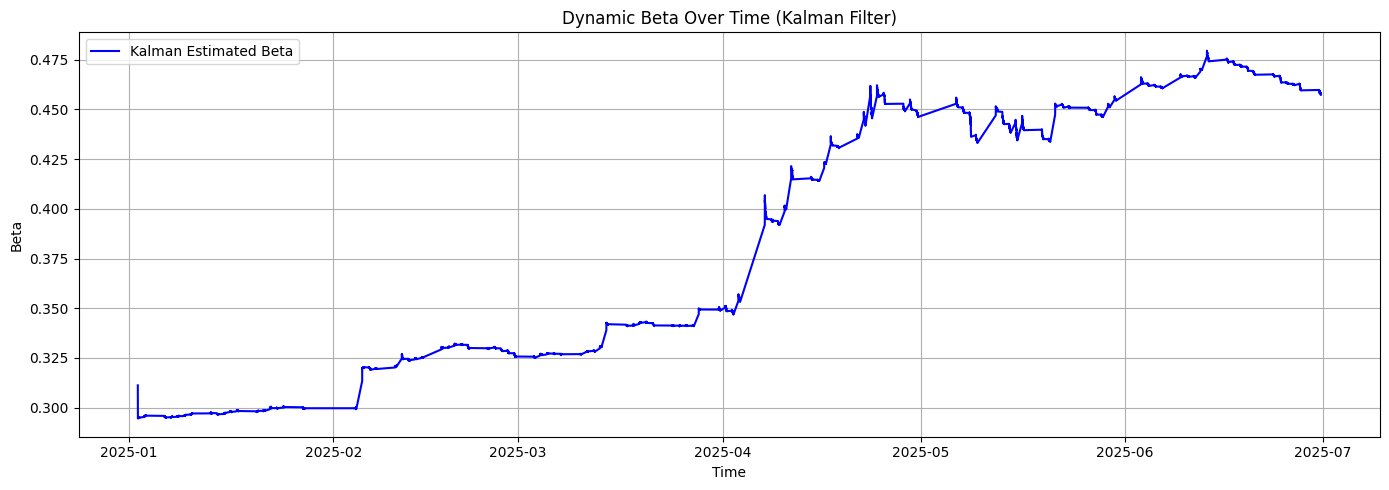

In [19]:
#画个图看看
plt.figure(figsize=(14, 5))
plt.plot(merged_result['DateTime'], merged_result['beta'], label='Kalman Estimated Beta', color='blue')
plt.title('Dynamic Beta Over Time (Kalman Filter)')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

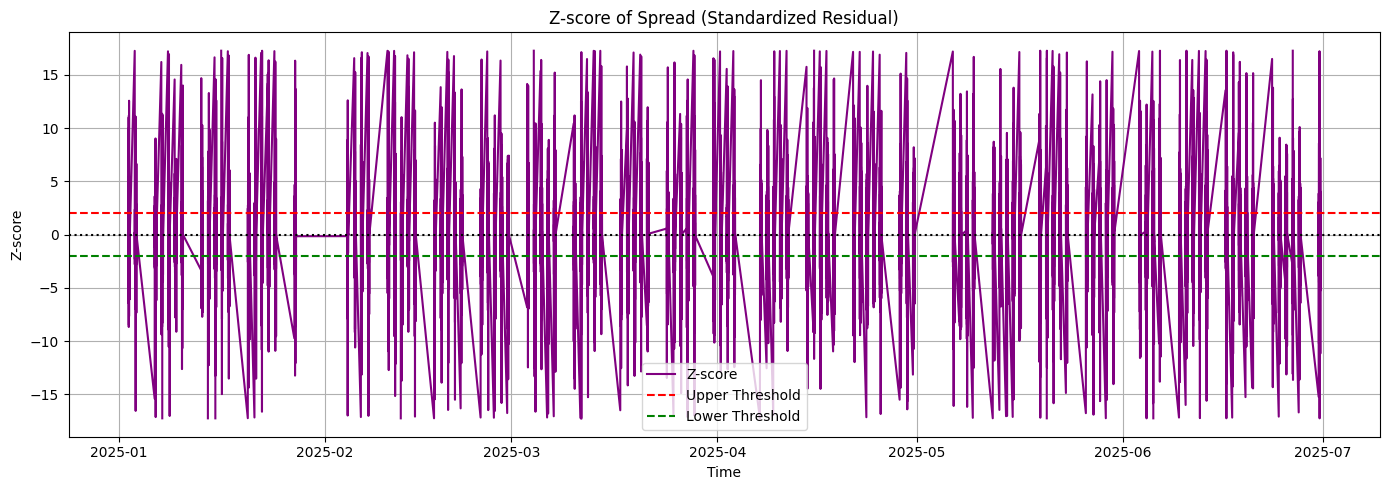

In [20]:
plt.figure(figsize=(14, 5))
plt.plot(merged_result['DateTime'], merged_result['zscore'], label='Z-score', color='purple')
plt.axhline(2, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(-2, color='green', linestyle='--', label='Lower Threshold')
plt.axhline(0, color='black', linestyle=':')
plt.title('Z-score of Spread (Standardized Residual)')
plt.xlabel('Time')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_8828/588518063.py:76: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_8828/588518063.py:76: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_8828/588518063.py:76: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_8828/588518063.py:76: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_8828/588518063.py:76: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53my

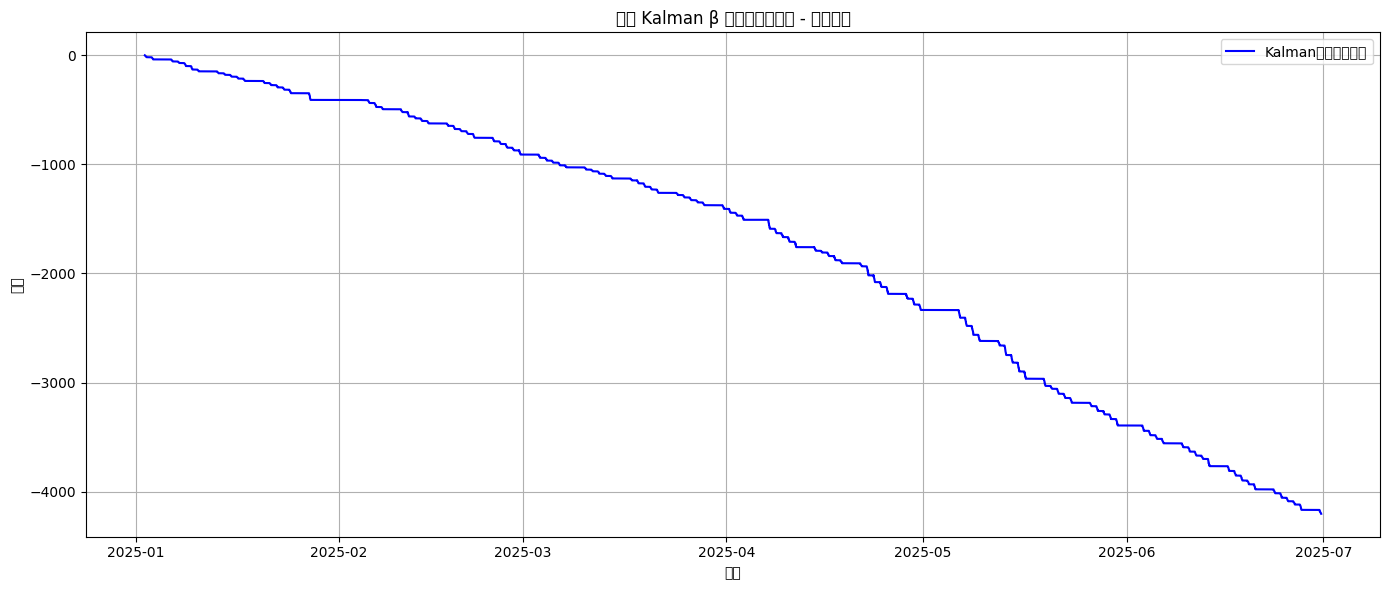

In [23]:
position = 0
entry_threshold = 2.0
exit_threshold = 0.1
etf_fee_rate = 0.0006  # ETF手续费双边万三

entry_price_etf = 0
entry_price_au = 0

pnl_list = []
position_list = []

last_z = 0  # 上一tick的z-score

# 遍历每一tick
for i in range(len(merged_result)):
    row = merged_result.iloc[i]
    z = row['zscore']
#撮合成交
    etf_buy = row['ETF_Sell1Price']      # 买入ETF（吃 ask1）
    etf_sell = row['ETF_Buy1Price']      # 卖出ETF（吃 bid1）
    au_buy = row['AU_Sell1Price']
    au_sell = row['AU_Buy1Price']

    pnl = 0

    if position == 0:
        if z > entry_threshold:
            # 空ETF多现货
            position = -1
            entry_price_etf = etf_sell
            entry_price_au = au_buy
        elif z < -entry_threshold:
            # 多ETF空现货
            position = 1
            entry_price_etf = etf_buy
            entry_price_au = au_sell
        pnl_list.append(0)
        position_list.append(position)

    elif position == 1:
        if abs(z) < exit_threshold:
            # 平多头：卖出ETF买入现货
            exit_etf = etf_sell
            exit_au = au_buy
            gross_pnl = (exit_etf - entry_price_etf) - (exit_au - entry_price_au)
            etf_cost = (entry_price_etf + exit_etf) * etf_fee_rate
            pnl = gross_pnl - etf_cost
            position = 0
        pnl_list.append(pnl)
        position_list.append(position)

    elif position == -1:
        if abs(z) < exit_threshold:
            # 平空头：买入ETF卖出现货
            exit_etf = etf_buy
            exit_au = au_sell
            gross_pnl = (entry_price_etf - exit_etf) - (entry_price_au - exit_au)
            etf_cost = (entry_price_etf + exit_etf) * etf_fee_rate
            pnl = gross_pnl - etf_cost
            position = 0
        pnl_list.append(pnl)
        position_list.append(position)

# 记录
merged['position_kalman'] = position_list
merged['pnl_kalman'] = pnl_list
merged['cum_pnl_kalman'] = merged['pnl_kalman'].cumsum()

plt.figure(figsize=(14, 6))
plt.plot(merged['DateTime'], merged['cum_pnl_kalman'], label='Kalman策略累计收益', color='blue')
plt.title("基于 Kalman β 的配对交易策略 - 累计收益")
plt.xlabel("时间")
plt.ylabel("收益")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_8828/1078308396.py:19: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_8828/1078308396.py:19: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_8828/1078308396.py:19: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_8828/1078308396.py:19: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_8828/1078308396.py:19: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2

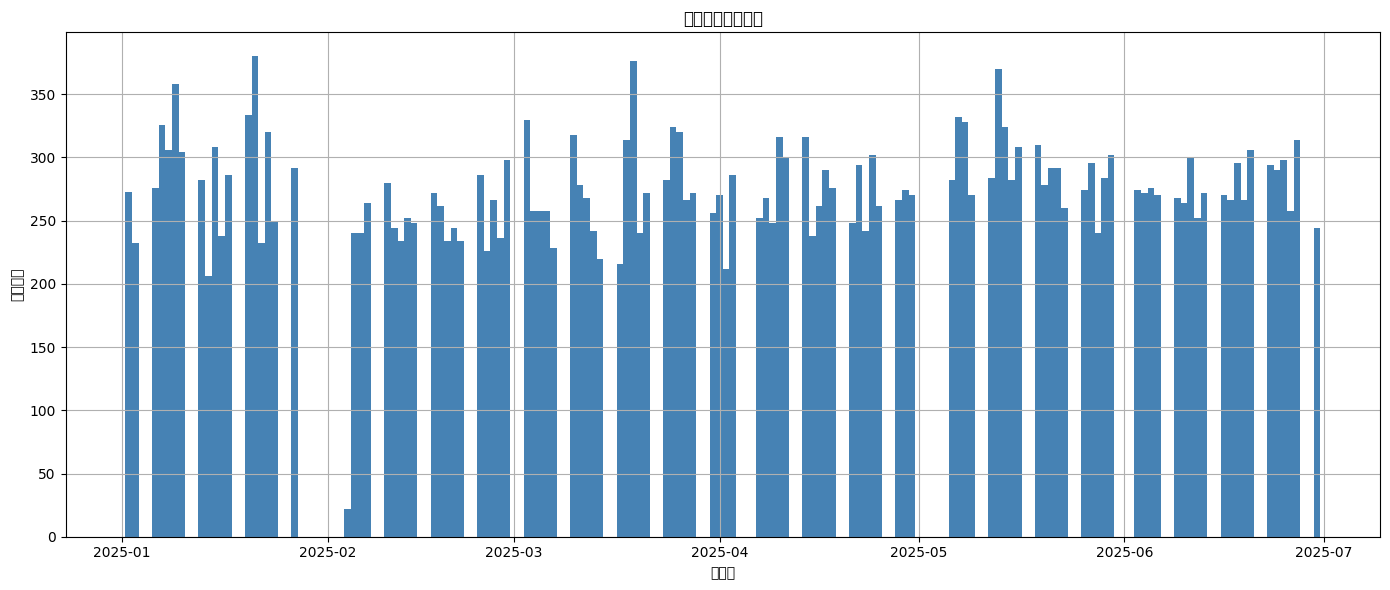

In [25]:
# 仓位变动：开仓或平仓
merged['position_shift'] = merged['position_kalman'].shift(1)
merged['position_change'] = merged['position_kalman'] != merged['position_shift']

# 取出变动的行，并提取日期
df_trades = merged[merged['position_change']].copy()
df_trades['date'] = df_trades['DateTime'].dt.date

# 每日交易次数统计
daily_trade_counts = df_trades.groupby('date').size().reset_index(name='trade_count')

# 画图
plt.figure(figsize=(14, 6))
plt.bar(daily_trade_counts['date'], daily_trade_counts['trade_count'], width=1.0, color='steelblue')
plt.title("每日交易次数分布")
plt.xlabel("交易日")
plt.ylabel("交易次数")
plt.grid(True)
plt.tight_layout()
plt.show()